# High-Frequency Grid Trading

<div class="alert alert-info">
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-upgrades-usd%E2%93%A2-margined-futures-liquidity-provider-program-2023-04-04-01007356e6514df3811b0c80ab8c83bf">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
    
</div>

## Plain High-Frequency Grid Trading

This is a high-frequency version of Grid Trading that keeps posting orders on grids centered around the mid-price, maintaining a fixed interval and a set number of grids.

In [3]:
from numba import njit
import pandas as pd
import numpy as np

from numba.typed import Dict

from hftbacktest import NONE, NEW, HftBacktest, GTX, FeedLatency, SquareProbQueueModel, BUY, SELL, Linear, Stat, reset

@njit
def gridtrading(hbt, stat):
    max_position = 5
    grid_interval = hbt.tick_size * 10
    grid_num = 20
    half_spread = hbt.tick_size * 20
        
    # Running interval in microseconds
    while hbt.elapse(100_000):
        # Clears cancelled, filled or expired orders.
        hbt.clear_inactive_orders()
        
        mid_price = (hbt.best_bid + hbt.best_ask) / 2.0
        bid_order_begin = np.floor((mid_price - half_spread) / grid_interval) * grid_interval
        ask_order_begin = np.ceil((mid_price + half_spread) / grid_interval) * grid_interval
        
        order_qty = 0.1
        last_order_id = -1
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.int64, np.float64)
        if hbt.position < max_position:
            for i in range(grid_num):
                bid_order_begin -= i * grid_interval
                bid_order_tick = round(bid_order_begin / hbt.tick_size)
                # Do not post buy orders above the best bid.
                if bid_order_tick > hbt.best_bid_tick:
                    continue
                    
                # order price in tick is used as order id.
                new_bid_orders[bid_order_tick] = bid_order_begin
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == BUY and order.cancellable and order.order_id not in new_bid_orders:
                hbt.cancel(order.order_id)
                last_order_id = order.order_id
        for order_id, order_price in new_bid_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_buy_order(order_id, order_price, order_qty, GTX)
                last_order_id = order_id
        
        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.int64, np.float64)
        if hbt.position > -max_position:
            for i in range(grid_num):
                ask_order_begin += i * grid_interval
                ask_order_tick = round(ask_order_begin / hbt.tick_size)
                # Do not post sell orders below the best ask.
                if ask_order_tick < hbt.best_ask_tick:
                    continue

                # order price in tick is used as order id.
                new_ask_orders[ask_order_tick] = ask_order_begin
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == SELL and order.cancellable and order.order_id not in new_ask_orders:
                hbt.cancel(order.order_id)
                last_order_id = order.order_id
        for order_id, order_price in new_ask_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_sell_order(order_id, order_price, order_qty, GTX)
                last_order_id = order_id
        
        # All order requests are considered to be requested at the same time.
        # Waits until one of the order responses is received.
        if last_order_id >= 0:
            if not hbt.wait_order_response(last_order_id):
                return False
        
        # Records the current state for stat calculation.
        stat.record(hbt)
    return True

In [2]:
hbt = HftBacktest(
    [
        'data/ethusdt_20221003.npz',
        'data/ethusdt_20221004.npz',
        'data/ethusdt_20221005.npz',
        'data/ethusdt_20221006.npz',
        'data/ethusdt_20221007.npz'
    ],
    tick_size=0.01,
    lot_size=0.001,
    maker_fee=-0.00005,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    queue_model=SquareProbQueueModel(),
    asset_type=Linear,
    snapshot='data/ethusdt_20221002_eod.npz'
)

stat = Stat(hbt)

Load data/ethusdt_20221003.npz


In [3]:
%%time
gridtrading(hbt, stat.recorder)

Load data/ethusdt_20221004.npz
Load data/ethusdt_20221005.npz
Load data/ethusdt_20221006.npz
Load data/ethusdt_20221007.npz
CPU times: user 3min 58s, sys: 6.03 s, total: 4min 4s
Wall time: 4min 5s


True

=========== Summary ===========
Sharpe ratio: 20.9
Sortino ratio: 22.4
Risk return ratio: 211.5
Annualised return: 330.53 %
Max. draw down: 1.56 %
The number of trades per day: 5954
Avg. daily trading volume: 595
Avg. daily trading amount: 798115
Max leverage: 0.52
Median leverage: 0.21


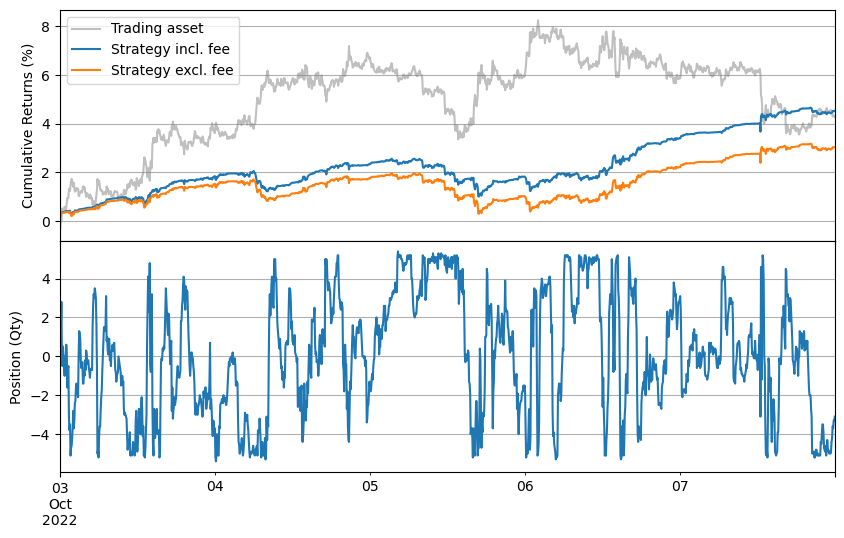

In [4]:
stat.summary(capital=15_000)

## High-Frequency Grid Trading with Skewing

By incorporating position-based skewing, the strategy's risk-adjusted returns can be improved.

In [5]:
@njit
def gridtrading(hbt, stat, skew):
    max_position = 5
    grid_interval = hbt.tick_size * 10
    grid_num = 20
    half_spread = hbt.tick_size * 20
        
    # Running interval in microseconds
    while hbt.elapse(100_000):
        # Clears cancelled, filled or expired orders.
        hbt.clear_inactive_orders()
        
        mid_price = (hbt.best_bid + hbt.best_ask) / 2.0
        reservation_price = mid_price - skew * hbt.position * hbt.tick_size
        bid_order_begin = np.floor((reservation_price - half_spread) / grid_interval) * grid_interval
        ask_order_begin = np.ceil((reservation_price + half_spread) / grid_interval) * grid_interval
        
        order_qty = 0.1 # np.round(notional_order_qty / mid_price / hbt.lot_size) * hbt.lot_size
        last_order_id = -1
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.int64, np.float64)
        if hbt.position < max_position: # hbt.position * mid_price < max_notional_position
            for i in range(grid_num):
                bid_order_begin -= i * grid_interval
                bid_order_tick = round(bid_order_begin / hbt.tick_size)
                # Do not post buy orders above the best bid.
                if bid_order_tick > hbt.best_bid_tick:
                    continue

                # order price in tick is used as order id.
                new_bid_orders[bid_order_tick] = bid_order_begin
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == BUY and order.cancellable and order.order_id not in new_bid_orders:
                hbt.cancel(order.order_id)
                last_order_id = order.order_id
        for order_id, order_price in new_bid_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_buy_order(order_id, order_price, order_qty, GTX)
                last_order_id = order_id
        
        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.int64, np.float64)
        if hbt.position > -max_position: # hbt.position * mid_price > -max_notional_position
            for i in range(grid_num):
                ask_order_begin += i * grid_interval
                ask_order_tick = round(ask_order_begin / hbt.tick_size)
                # Do not post sell orders below the best ask.
                if ask_order_tick < hbt.best_ask_tick:
                    continue
                    
                # order price in tick is used as order id.
                new_ask_orders[ask_order_tick] = ask_order_begin
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == SELL and order.cancellable and order.order_id not in new_ask_orders:
                hbt.cancel(order.order_id)
                last_order_id = order.order_id
        for order_id, order_price in new_ask_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_sell_order(order_id, order_price, order_qty, GTX)
                last_order_id = order_id
        
        # All order requests are considered to be requested at the same time.
        # Waits until one of the order responses is received.
        if last_order_id >= 0:
            if not hbt.wait_order_response(last_order_id):
                return False
        
        # Records the current state for stat calculation.
        stat.record(hbt)
    return True

Weak skew

Load data/ethusdt_20221003.npz
Load data/ethusdt_20221004.npz
Load data/ethusdt_20221005.npz
Load data/ethusdt_20221006.npz
Load data/ethusdt_20221007.npz
=========== Summary ===========
Sharpe ratio: 18.0
Sortino ratio: 17.5
Risk return ratio: 169.2
Annualised return: 166.77 %
Max. draw down: 0.99 %
The number of trades per day: 6488
Avg. daily trading volume: 648
Avg. daily trading amount: 870207
Max leverage: 0.50
Median leverage: 0.10


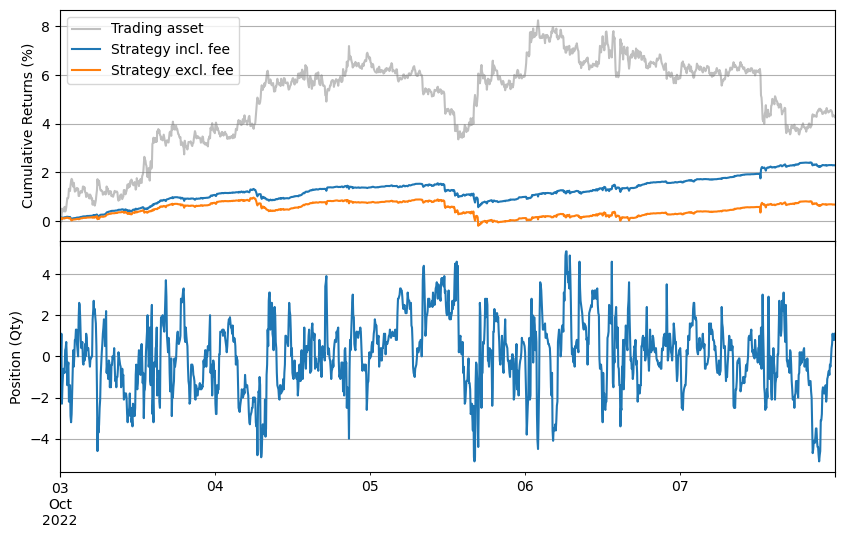

In [6]:
reset(
    hbt,
    [
        'data/ethusdt_20221003.npz',
        'data/ethusdt_20221004.npz',
        'data/ethusdt_20221005.npz',
        'data/ethusdt_20221006.npz',
        'data/ethusdt_20221007.npz'
    ],
    snapshot='data/ethusdt_20221002_eod.npz'
)

stat = Stat(hbt)
skew = 1

gridtrading(hbt, stat.recorder, skew)

stat.summary(capital=15_000)

Strong skew

Load data/ethusdt_20221003.npz
Load data/ethusdt_20221004.npz
Load data/ethusdt_20221005.npz
Load data/ethusdt_20221006.npz
Load data/ethusdt_20221007.npz
=========== Summary ===========
Sharpe ratio: 29.3
Sortino ratio: 33.4
Risk return ratio: 735.4
Annualised return: 100.30 %
Max. draw down: 0.14 %
The number of trades per day: 6636
Avg. daily trading volume: 663
Avg. daily trading amount: 889749
Max leverage: 0.51
Median leverage: 0.02


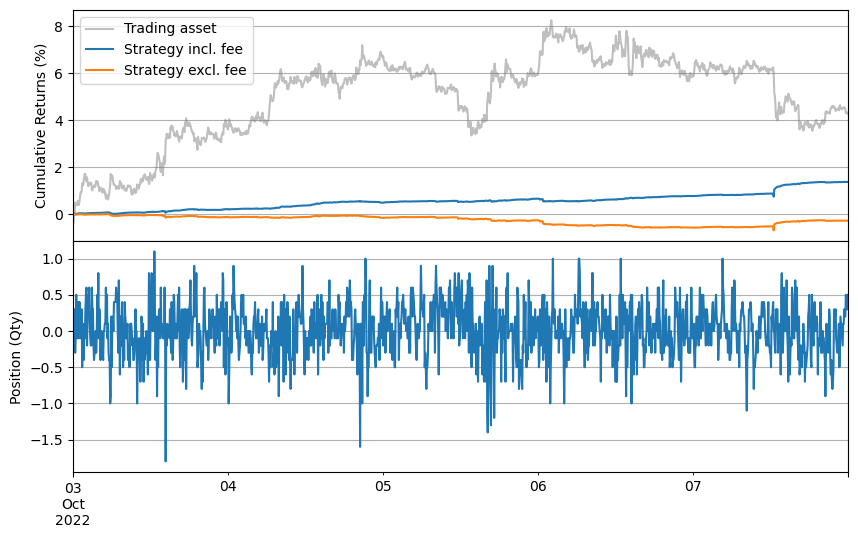

In [7]:
reset(
    hbt,
    [
        'data/ethusdt_20221003.npz',
        'data/ethusdt_20221004.npz',
        'data/ethusdt_20221005.npz',
        'data/ethusdt_20221006.npz',
        'data/ethusdt_20221007.npz'
    ],
    snapshot='data/ethusdt_20221002_eod.npz'
)

stat = Stat(hbt)
skew = 10
gridtrading(hbt, stat.recorder, skew)

stat.summary(capital=15_000)

## Multiple Assets

You might need to find the proper parameters for each asset to achieve better performance. As an example, here it uses single parameters set to demonstrate how the performance of a combination of multiple assets will be.

In [8]:
@njit
def gridtrading(hbt, stat, half_spread, grid_interval, skew, order_qty):
    grid_num = 20
    max_position = grid_num * order_qty
        
    # Running interval in microseconds
    while hbt.elapse(100_000):       
        mid_price = (hbt.best_bid + hbt.best_ask) / 2.0        
        
        normalized_position = hbt.position / order_qty
        
        bid_depth = half_spread + skew * normalized_position
        ask_depth = half_spread - skew * normalized_position

        bid_price = min(mid_price - bid_depth, hbt.best_bid)
        ask_price = max(mid_price + ask_depth, hbt.best_ask)
        
        grid_interval = max(np.round(half_spread / hbt.tick_size) * hbt.tick_size, hbt.tick_size)
        
        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        hbt.clear_inactive_orders()
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.int64, np.float64)
        if hbt.position < max_position and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price -= i * grid_interval
                bid_price_tick = round(bid_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[bid_price_tick] = bid_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == BUY and order.cancellable and order.order_id not in new_bid_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_bid_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_buy_order(order_id, order_price, order_qty, GTX)
        
        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.int64, np.float64)
        if hbt.position > -max_position and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price += i * grid_interval
                ask_price_tick = round(ask_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[ask_price_tick] = ask_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == SELL and order.cancellable and order.order_id not in new_ask_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_ask_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_sell_order(order_id, order_price, order_qty, GTX)
        
        # Records the current state for stat calculation.
        stat.record(hbt)
    return True

In [9]:
from hftbacktest import IntpOrderLatency, LogProbQueueModel2, COL_PRICE, COL_SIDE

latency_data = np.concatenate(
    [np.load('../latency/order_latency_{}.npz'.format(date))['data'] for date in range(20230701, 20230732)]
)
    
def backtest(args):
    asset_name, asset_info = args

    hbt = HftBacktest(
        ['data/{}_{}.npz'.format(asset_name, date) for date in range(20230701, 20230732)],
        tick_size=asset_info['tick_size'],
        lot_size=asset_info['lot_size'],
        maker_fee=-0.00005,
        taker_fee=0.0007,
        order_latency=IntpOrderLatency(data=latency_data),
        queue_model=LogProbQueueModel2(),
        asset_type=Linear,
        snapshot='data/{}_20230630_eod.npz'.format(asset_name)
    )

    stat = Stat(hbt)

    # Obtains the mid-price of the assset to determine the order quantity.
    data = np.load('data/{}_20230630_eod.npz'.format(asset_name))['data']
    best_bid = max(data[data[:, COL_SIDE] == 1][:, COL_PRICE])
    best_ask = min(data[data[:, COL_SIDE] == -1][:, COL_PRICE])
    mid = (best_bid + best_ask) / 2.0

    # Sets the order quantity to be equivalent to a notional value of $100.
    order_qty = max(round((100 / mid) / asset_info['lot_size']), 1) * asset_info['lot_size']

    half_spread = mid * 0.0008
    grid_interval = mid * 0.0008
    
    skew = mid * 0.000025
    gridtrading(hbt, stat.recorder, half_spread, grid_interval, skew, order_qty)

    np.savez(
        'stats/{}_stat_grid_multi'.format(asset_name),
        timestamp=np.asarray(stat.timestamp),
        mid=np.asarray(stat.mid),
        balance=np.asarray(stat.balance),
        position=np.asarray(stat.position),
        fee=np.asarray(stat.fee),
    )

In [10]:
%%capture

import json
from multiprocessing import Pool

with open('assets.json', 'r') as f:
    assets =  json.load(f)

with Pool(16) as p:
    print(p.map(backtest, list(assets.items())))

Text(0, 0.5, 'Cumulative Returns (%)')

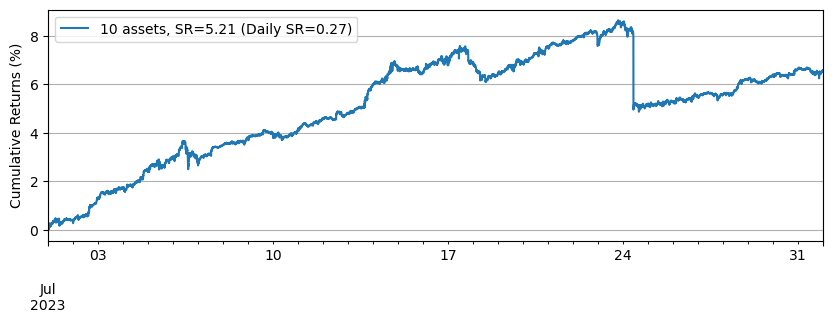

In [11]:
from matplotlib import pyplot as plt

equity_values = {}
for asset_name in assets.keys():
    stat = np.load('stats/{}_stat_grid.npz'.format(asset_name))
    timestamp = stat['timestamp']
    mid = stat['mid']
    balance = stat['balance']
    position = stat['position']
    fee = stat['fee']
    
    equity = mid * position + balance - fee
    equity = pd.Series(equity, index=pd.to_datetime(timestamp, unit='us', utc=True))
    equity_values[asset_name] = equity.resample('5min').last()
    
fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
for i, equity in enumerate(list(equity_values.values())):
    asset_number = i + 1
    if net_equity is None:
        net_equity = equity.copy()
    else:
        net_equity += equity.copy()

    if asset_number % 10 == 0:
        # 2_000 is capital for each trading asset.
        net_equity_ = (net_equity / asset_number) / 2_000
        net_equity_rs = net_equity_.resample('1d').last()
        pnl = net_equity_rs.diff()
        sr = pnl.mean() / pnl.std()
        ann_sr = sr * np.sqrt(365)
        legend.append('{} assets, SR={:.2f} (Daily SR={:.2f})'.format(asset_number, ann_sr, sr))
        (net_equity_ * 100).plot()
        
plt.legend(legend)
plt.grid()
plt.ylabel('Cumulative Returns (%)')